In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib as mpl
from datetime import datetime
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation


mpl.rcParams['figure.figsize'] = (20, 15)
mpl.rcParams['axes.grid'] = False

import tensorflow as tf 
np.random.seed(42)
tf.random.set_seed(42)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d4fe292d0>,
      dtype=object)

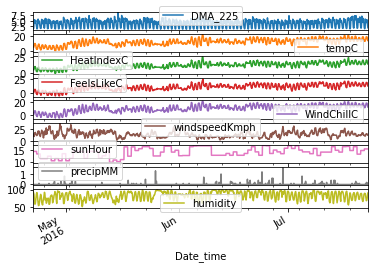

In [3]:
data = pd.read_csv("/content/gdrive/My Drive/Thesis/dataframe_flow_variable_60min.csv")
data['Unnamed: 0'] = pd.to_datetime(data['Unnamed: 0'])
data.rename( columns={'Unnamed: 0':'Date_time','225':'DMA_225'}, inplace=True )
data_DMA225 = data[['Date_time','DMA_225','tempC','HeatIndexC','FeelsLikeC','WindChillC','windspeedKmph','sunHour','precipMM','humidity']]
data_DMA225_indexed = data_DMA225.set_index('Date_time')
data_DMA225_indexed[['DMA_225','tempC','HeatIndexC','FeelsLikeC','WindChillC','windspeedKmph','sunHour','precipMM','humidity']].plot(subplots=True)

In [4]:
# Making hourly data 
hourly_data = data_DMA225_indexed.resample('h').sum()

#Train and test split
#split = 240
train = hourly_data[:-442]
test = hourly_data[-442:]

In [5]:
#Separate dates for future plotting
trainset = train.reset_index()
train_dates = pd.to_datetime(trainset['Date_time'])
len(train_dates)

1766

In [6]:
#Variables for training
cols = list(train)[:10]
df_for_training = train[cols]

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
df_for_training_scaled.shape

(1766, 9)

In [7]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 24  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX, trainY = np.array(trainX), np.array(trainY)


trainX shape == (1742, 24, 9).
trainY shape == (1742, 1).


In [8]:
import tensorflow
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LeakyReLU(alpha=0.9)) 
model.add(Dropout(0.15))
model.add(LSTM(64,activation='relu',return_sequences=True))
model.add(LeakyReLU(alpha=0.9))
model.add(LSTM(32,activation='relu',return_sequences=False))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))

model.add(Dense(trainY.shape[1]))

#opt = keras.optimizers.Adam(lr = 0.009)
model.compile(optimizer='adam', loss='mae')
model.summary()


# fit the model
history = model.fit(trainX, trainY, epochs=50, batch_size=2000, validation_split=0.2, verbose=1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            18944     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 24, 64)            0         
                                                                 
 dropout (Dropout)           (None, 24, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 24, 64)            33024     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 24, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32)                0

In [10]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

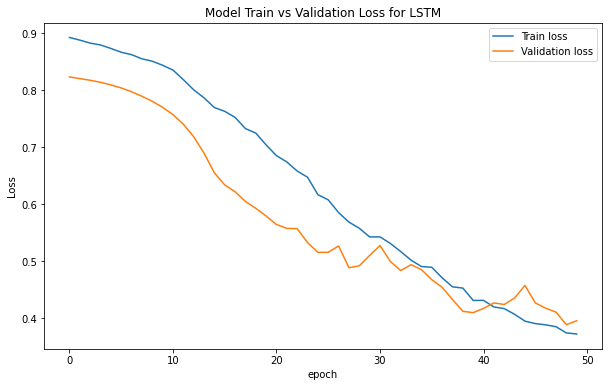

In [11]:
plot_loss(history,'LSTM')

In [12]:
n_past = 24
n_days_for_prediction=264  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq='1H').tolist()

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:])
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [13]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i)
    
df_forecast = pd.DataFrame({'Date_time':np.array(forecast_dates), 'DMA_225_pred':y_pred_future})
df_forecast['Date_time']=pd.to_datetime(df_forecast['Date_time'])

# making predicted df

df1=df_forecast[24:]
df1= df1.reset_index()
df1= df1.drop(['index'], axis=1)

# test dataset

t1 = test.reset_index()
t1 = t1[['Date_time','DMA_225']]

# final df
fd=pd.merge(t1, df1, on="Date_time")

In [14]:
#Calculate rmse
# Root Mean Square Error (RMSE)
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
rmse = np.sqrt(mean_squared_error(fd.DMA_225,fd.DMA_225_pred))
rmse = round(rmse, 3)
print (" The root mean square vaue on testset: ",rmse)

 The root mean square vaue on testset:  0.752


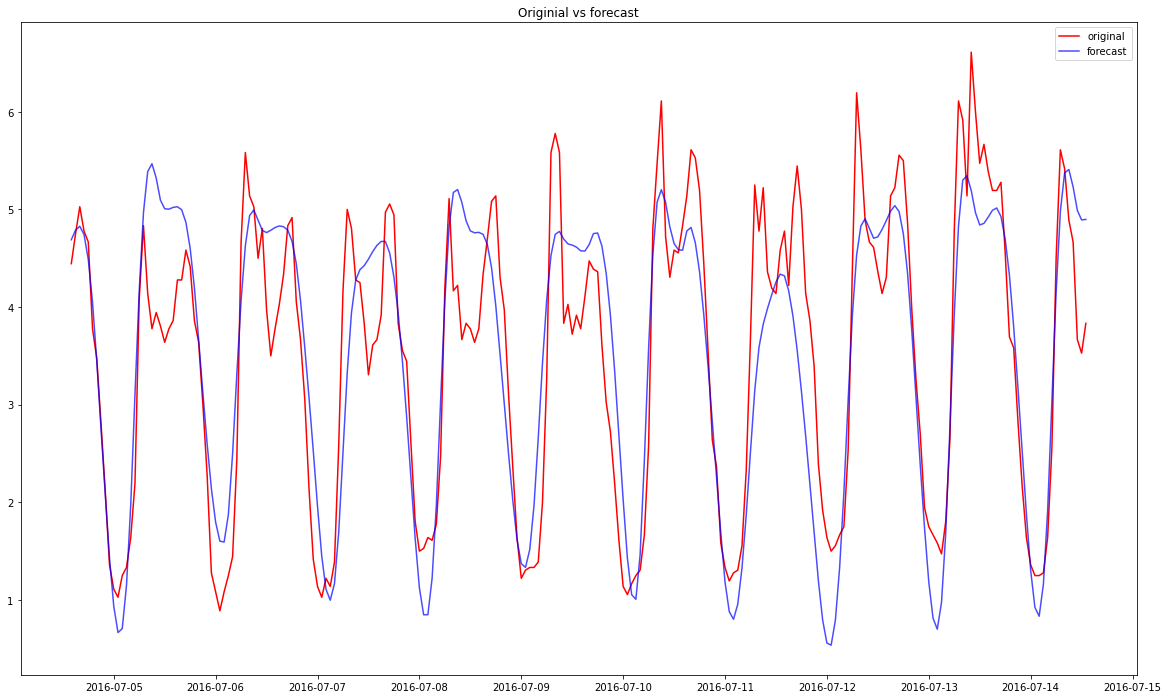

In [15]:
# Plotting original and predicted graph:
plt.figure(figsize=(20, 12))
plt.plot(fd.Date_time, fd.DMA_225, color='red', label='original')
plt.plot(fd.Date_time, fd.DMA_225_pred, color='blue', label='forecast', alpha=0.7)
plt.title('Originial vs forecast')
plt.legend()
plt.show()